# ASSIGNMENT 3
The task of the assignment #3 is the design of a CNN architecture and its training.

Input dataset: MNIST digits (input size 28x28x1, number of classes: 10).
The dataset is not distributed since can be easily downloaded directly from Keras.

The CNN has to be designed with the aim of reaching the maximum possible accuracy on the test set, with the hard constraint of a maximum of 6K learnable parameters. Refer to the code developed in today's class as a skeleton on which to build your solution.

The report must contain:
- a description of the designed architecture
- the parameters count for each layer
- the hyper-parameters used for training (batch size, learning rate, optimizer, number of epochs, etc)
- a plot of the training and validation loss/accuracy 
- classification performance on training, validation (if used) and test set



### Imports

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

## LOADING DATA AND PREPROCESSING

In [2]:
num_classes = 10
input_shape = (28,28,1)
# load data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# scale images in [0,1]
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255
# images 28x28
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train_shape: ", x_train.shape)

# convert class vectors to binary class matrices
print("y_train_shape: ", y_train.shape)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print("y_train_shape: ", y_train.shape)

x_train_shape:  (60000, 28, 28, 1)
y_train_shape:  (60000,)
y_train_shape:  (60000, 10)


Split Training and Validation Data

In [3]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, train_size=0.9)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(54000, 28, 28, 1)
(54000, 10)
(6000, 28, 28, 1)
(6000, 10)


## BUILDING THE MODEL

### CNN structure

La rete utilizzata utilizza due convolutional layer, seguiti entrambi da un maxpool. Infine abbiamo un layer fully connected con numero di neuroni uguale al numero delle classi del nostro task di classificazione. 
- Per il primo convolutional layer sono stati utilizzati 33 filtri, una kernel size di 3x3, strides di (1,1) e funzione di attivazione relu. Otteniamo così in output le stesse dimensioni delle immagini originali (una per ciascun filtro).
- Successivamente andiamo a fare un'operazione di max pooling (2,2), dimezzando così la dimensione delle immagini da 26x26 a 13x13.
- Per il secondo convolutional layer sono stati utilizzati 25 filtri, una kernel size di 2x2, strides di (1,1) e funzione di attivazione relu. Passiamo quindi ad una dimensione delle immagini di 12x12. (una per ciascun filtro).
- Successivamente andiamo a fare un'operazione di max pooling (4,4), rendendo così la dimensione delle immagini da 12x12 a 3x3.
- Nel passaggio successivo andiamo a perdere la configurazione spaziale, collegando un array monodimensionale fully connected di dimensione 10 (numero classi). Utilizziamo la tecnica di regolarizzazione del dropout, per evitare overfitting. La funzione di attivazione utilizzata in output è la softmax.

Rispetto alla rete originale(quella presentata in aula) è stato quindi solo ridotto il numero di filtri utilizzati, in particolar modo quelli del secondo layer convolutivo (e raddoppiato il pooling dopo il secondo layer convolutivo). Ciò si rivelerà una scelta efficace perchè intuitivamente non si ha bisogno di un grande numero di filtri per riconoscere delle semplici immagini raffiguranti cifre: tali immagini non hanno particolari texture da riconoscere o feature complesse come un volto, ma solamente feature di base come linee e cerchi. Un numero di filtri basso quindi si rivelerà più che sufficiente.

In [4]:
model = keras.Sequential(
    [
     keras.Input(shape=input_shape),
     layers.Conv2D(33, kernel_size=(3,3), activation="relu", strides=(1,1)),
     layers.MaxPooling2D(pool_size=(2,2)),
     layers.Conv2D(25, kernel_size=(2,2), activation="relu", strides=(1,1)),
     layers.MaxPooling2D(pool_size=(4,4)),
     layers.Flatten(),
     layers.Dropout(0.1),
     layers.Dense(num_classes, activation="softmax")     
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 33)        330       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 33)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 25)        3325      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 25)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 225)               0         
                                                                 
 dropout (Dropout)           (None, 225)               0

- Il primo layer di convoluzione ha 330 parametri
- Il secondo layer di convoluzione ha 3325 parametri
- L'ultimo layer (fully connected) ha 2260 parametri

Totale numero di parametri: 5,915

### Rete alternativa provata in partenza

In partenza si era anche provato, per tenere il numero di parametri sotto i 6000, ad utilizzare uno stride uguale alla dimensione della maskera kernel della convoluzione, solamente che le performance sono risultate inferiori in accuracy dell'1% rispetto alla rete finale che siamo andati a considerare. Non era stato utilizzato pooling. In seguito la struttura della rete che era stata utilizzata.

In [5]:
'''
model = keras.Sequential(
    [
     keras.Input(shape=input_shape),
     layers.Conv2D(33, kernel_size=(7,7), activation="relu", strides=(7,7)),
     layers.Conv2D(25, kernel_size=(2,2), activation="relu", strides=(2,2)),
     layers.Flatten(),
     layers.Dropout(0.1),
     layers.Dense(num_classes, activation="softmax")     
    ]
)

model.summary()
'''

'\nmodel = keras.Sequential(\n    [\n     keras.Input(shape=input_shape),\n     layers.Conv2D(33, kernel_size=(7,7), activation="relu", strides=(7,7)),\n     layers.Conv2D(25, kernel_size=(2,2), activation="relu", strides=(2,2)),\n     layers.Flatten(),\n     layers.Dropout(0.1),\n     layers.Dense(num_classes, activation="softmax")     \n    ]\n)\n\nmodel.summary()\n'

### Training

- La batch_size utilizzata è 128
- Il numero di epochs è di 50, andando oltre si iniziava ad andare in overfitting
- Optimizer: adam, si è provato con SGD e altri ma risultavano molto più lenti.
- Learning rate: default, 0.001
- Loss: categorical crossentropy


In [6]:
batch_size = 128
epochs = 50

model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001) , metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

Epoch 1/50
422/422 [==============================] - 6s 10ms/step - loss: 0.6695 - accuracy: 0.7965 - val_loss: 0.1784 - val_accuracy: 0.9478
Epoch 2/50
422/422 [==============================] - 4s 9ms/step - loss: 0.1864 - accuracy: 0.9412 - val_loss: 0.1194 - val_accuracy: 0.9637
Epoch 3/50
422/422 [==============================] - 4s 9ms/step - loss: 0.1404 - accuracy: 0.9561 - val_loss: 0.0934 - val_accuracy: 0.9707
Epoch 4/50
422/422 [==============================] - 4s 8ms/step - loss: 0.1152 - accuracy: 0.9631 - val_loss: 0.0798 - val_accuracy: 0.9768
Epoch 5/50
422/422 [==============================] - 4s 9ms/step - loss: 0.1000 - accuracy: 0.9685 - val_loss: 0.0774 - val_accuracy: 0.9763
Epoch 6/50
422/422 [==============================] - 4s 9ms/step - loss: 0.0901 - accuracy: 0.9718 - val_loss: 0.0651 - val_accuracy: 0.9813
Epoch 7/50
422/422 [==============================] - 4s 9ms/step - loss: 0.0819 - accuracy: 0.9738 - val_loss: 0.0615 - val_accuracy: 0.9818
Epoch

## CLASSIFICATION PERFORMANCE

### Plot of accuracy and loss on training and validation set

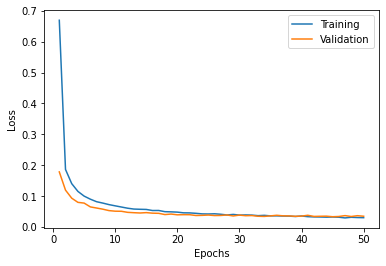

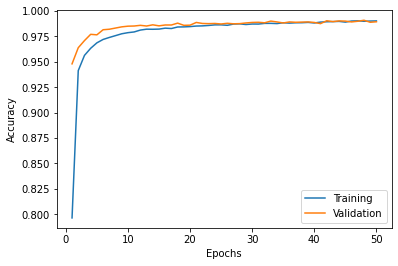

In [7]:
#plot training history

from matplotlib import pyplot as plt
x_plot = list(range(1, epochs+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(history)

La validation loss risulta decrescente, fino a un valore praticamente stazionario, segnale che mostra che è il momento giusto per fermarsi e non avere un numero di epochs maggiore, poichè si andrebbe in overfitting.
La train e validation accuracy dopo 50 epochs sono circa uguali, proseguendo con il training per altre epochs vedremmo la training accuracy aumentare e la validation accuracy diminuire: overfitting.

### Training set

In [8]:
train_predictions = model.predict(x_train)
train_classes_pred=np.argmax(train_predictions,axis=1)
print("CLASSIFICATION PERFORMANCE TRAINING SET\n")
print("First 20 classes predicted: \n", train_classes_pred[:20])
train_true_values=np.argmax(y_train,axis=1)
print("First 20 true classes: \n", train_true_values[:20])
print("\n", classification_report(train_true_values,train_classes_pred, digits=3))

CLASSIFICATION PERFORMANCE TRAINING SET

First 20 classes predicted: 
 [7 1 8 1 1 6 6 6 0 1 5 1 0 3 0 8 3 8 1 7]
First 20 true classes: 
 [7 1 8 1 1 6 6 6 0 1 5 1 0 3 0 8 3 8 1 7]

               precision    recall  f1-score   support

           0      0.998     0.997     0.998      5319
           1      0.996     0.999     0.997      6094
           2      0.995     0.995     0.995      5387
           3      0.997     0.995     0.996      5552
           4      0.991     0.997     0.994      5240
           5      0.998     0.994     0.996      4860
           6      0.993     0.999     0.996      5299
           7      0.995     0.991     0.993      5628
           8      0.992     0.995     0.994      5249
           9      0.996     0.990     0.993      5372

    accuracy                          0.995     54000
   macro avg      0.995     0.995     0.995     54000
weighted avg      0.995     0.995     0.995     54000



### Validation set

In [9]:
val_predictions = model.predict(x_val)
val_classes_pred=np.argmax(val_predictions,axis=1)
print("CLASSIFICATION PERFORMANCE VALIDATION SET\n")
print("First 20 classes predicted: \n", val_classes_pred[:20])
val_true_values=np.argmax(y_val,axis=1)
print("First 20 true classes: \n", val_true_values[:20])
print("\n", classification_report(val_true_values,val_classes_pred, digits=3))

CLASSIFICATION PERFORMANCE VALIDATION SET

First 20 classes predicted: 
 [5 1 1 0 7 0 4 4 8 3 8 1 0 6 0 5 5 1 7 8]
First 20 true classes: 
 [5 1 1 0 7 0 4 4 8 3 8 1 0 6 0 5 5 1 7 8]

               precision    recall  f1-score   support

           0      0.993     0.992     0.993       604
           1      0.994     0.994     0.994       648
           2      0.991     0.995     0.993       571
           3      0.998     0.988     0.993       579
           4      0.979     0.995     0.987       602
           5      0.993     0.986     0.989       561
           6      0.982     0.997     0.990       619
           7      0.989     0.992     0.991       637
           8      0.983     0.985     0.984       602
           9      0.989     0.967     0.978       577

    accuracy                          0.989      6000
   macro avg      0.989     0.989     0.989      6000
weighted avg      0.989     0.989     0.989      6000



### Test set

In [10]:
test_predictions = model.predict(x_test)
test_classes_pred=np.argmax(test_predictions,axis=1)
print("CLASSIFICATION PERFORMANCE TEST SET\n")
print("First 20 classes predicted: \n", test_classes_pred[:20])
test_true_values=np.argmax(y_test,axis=1)
print("First 20 true classes: \n", test_true_values[:20])
print("\n",classification_report(test_true_values,test_classes_pred, digits=3))

CLASSIFICATION PERFORMANCE TEST SET

First 20 classes predicted: 
 [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
First 20 true classes: 
 [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]

               precision    recall  f1-score   support

           0      0.990     0.996     0.993       980
           1      0.991     0.995     0.993      1135
           2      0.986     0.991     0.989      1032
           3      0.994     0.992     0.993      1010
           4      0.986     0.991     0.988       982
           5      0.992     0.992     0.992       892
           6      0.991     0.989     0.990       958
           7      0.991     0.987     0.989      1028
           8      0.986     0.989     0.987       974
           9      0.992     0.977     0.985      1009

    accuracy                          0.990     10000
   macro avg      0.990     0.990     0.990     10000
weighted avg      0.990     0.990     0.990     10000



Abbiamo una accuracy di 0.995 sul training set, di 0.989 sul validation set e di 0.990 sul test set. I risultati quindi risultano del tutto soddisfacenti, considerando il vincolo di poter utilizzare solamente 6000 parametri nella CNN. Non vi sono differenze importanti sulle varie classi tra le misure di performance calcolate.